# MobileNetV2 Transfer Learning TensorFlow's Flowers Dataset

* Using a MobileNetV2 Convolutional Neural Network (CNN) to classify flower types without retraining;
* Dataset with 3670 pictures of 5 types of flowers: daisy, dandelion, rose, sunflower, tulip;
* 15% of the data is used for validation and 15% for testing;
* Pictures vary in resolution, but are all converted to 224x224. No data augmentation is performed;
* MobileNetV2 was originally proposed in: https://arxiv.org/abs/1801.04381

In [ ]:
import tarfile
import os
import shutil

import numpy as np
import seaborn as sns
from tensorflow import keras
import tensorflow_hub as hub
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

## Model Exploration

Since this is a transfer learning task, we start by exploring the capabilities of the MobileNetV2 CNN model. Let us load the model and instantiate it using the Sequential framework from Keras. The Sequential framework is appropriate as MobileNetV2 only has a single stream of layers.

The MobileNetV2 model was trained on [ImageNet](https://www.image-net.org/index.php) dataset, therefore, it is able to classify many images. We can try it out by feeding it a random image, in our case, a picture of a lion.

In [ ]:
mobilenetv2_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

# Since this model was trained on ImageNet, we use the 224x224 input shape.
mobilenetv2 = keras.Sequential([hub.KerasLayer(mobilenetv2_url,
                                               input_shape=(224, 224, 3))])

35363/35363 [==============================] - 0s 0us/step


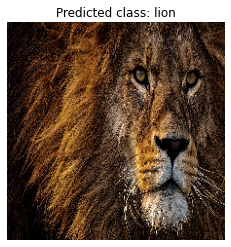

In [ ]:
sample_image = keras.preprocessing.image.load_img('/content/Lion.jpg',
                                                  target_size=(224, 224))

# The TF Hub MobileNetV2 expects image pixels normalized between
# 0 and 1.
sample_image = np.array(sample_image) / 255.0

predicted_class = mobilenetv2.predict(np.expand_dims(sample_image, axis=0))
predicted_class = keras.applications.mobilenet_v2.decode_predictions(
    predicted_class[:, 1:], top=1
)
predicted_class = np.ravel(predicted_class)

plt.imshow(sample_image)
plt.title("Predicted class: " + predicted_class[1])
plt.axis('off')
plt.show()

MobileNetV2 was successfully able to classify the animal in the image as a lion. However, it is important to note that "lion" is a class in ImageNet. For our flower dataset we do not have correspondent classes in ImageNet.

## Data Exploration

After downloading our dataset from Tensorflow's repository, we need to split it between training (including validation) and testing sets. As every image is downloaded in a single folder, we can just select a percentage of them and move them to a testing folder. We go with a 70/15/15 dataset split for our training session here.

In [ ]:
flowers_dataset_path = keras.utils.get_file(
    '/content/flower_photos.tgz',
    origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
)

# Unzip the file on the download path.
tarfile_obj = tarfile.open(flowers_dataset_path)
tarfile_obj.extractall("./")
tarfile_obj.close()

# Make all directories needed to create our testing set.
os.mkdir('/content/flower_photos_test')
os.mkdir('/content/flower_photos_test/daisy')
os.mkdir('/content/flower_photos_test/dandelion')
os.mkdir('/content/flower_photos_test/roses')
os.mkdir('/content/flower_photos_test/sunflowers')
os.mkdir('/content/flower_photos_test/tulips')

# We do not need the LICENSE file, so remove it.
try:
    os.remove('/content/flower_photos/LICENSE.txt')
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

# Count the number of samples to calculate a data-driven batch size.
num_samples = 0
for dir_path, dir_names, files in os.walk('/content/flower_photos'):
    num_samples += len(files)

    for file_name in files:
        # 15% percent chances of the number generated being smaller than 0.15,
        # the same percentage of our testing set.
        if np.random.rand(1) < 0.15:
            shutil.move(dir_path[:] + '/' + file_name,
                        dir_path[:22] + "_test" + dir_path[22:] + '/' + file_name)

print("Total number of photos: ", num_samples)

228813984/228813984 [==============================] - 9s 0us/step
Total number of photos:  3670


Before seing what our data looks like, we can instantiate our data generators. We argue that 50 batches with 62 images is a reasonable setting for our training.

Other than that, we rescale our images to be in the [0, 1] range to help the model converge faster. Images are also expected to have their values in this range for the imported MobileNetV2 model.

In [ ]:
# Training samples: total number of samples minus 15% for testing.
num_training_samples = num_samples - num_samples * 0.15

# 50 batches of 62 images.
batch_size = int(num_training_samples / 50)

# Rescale images to [0, 1] to help the model converge faster.
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    validation_split=0.15
)

train_flow = train_datagen.flow_from_directory('/content/flower_photos',
                                               batch_size=batch_size,
                                               target_size=(224, 224),
                                               subset='training')

validation_flow = train_datagen.flow_from_directory('/content/flower_photos',
                                                    batch_size=batch_size,
                                                    target_size=(224, 224),
                                                    subset='validation')

Found 2667 images belonging to 5 classes.
Found 467 images belonging to 5 classes.


In the next grid, 16 random images are taken from the first batch of the training generator and plotted. This way, we can grab a look on how our images look like. Labels are printed above each image.

Since our labels are originally one-hot encoded, we use Scikit-learn's `OneHotEncoder` to quickly revert the label encoding to class names.

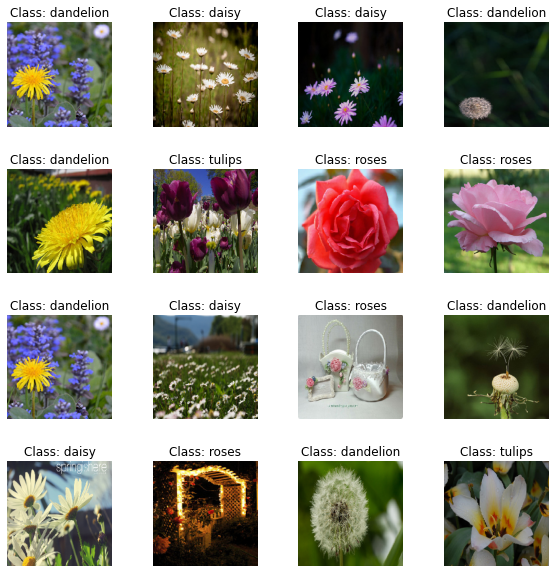

In [ ]:
# Get first batch as a dataset sample to use in the grid.
grid_batch = train_flow.__getitem__(0)

# Class names to reverse the one-hot encoding.
labels = np.array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
labels = labels.reshape(-1, 1)

# Reverse one-hot encoding to plot the actual flower names in the grid.
encoder = OneHotEncoder()
encoder.fit(labels)
batch_labels = encoder.inverse_transform(grid_batch[1]).flatten()

grid_height = 4
grid_width = 4

fig, axes = plt.subplots(grid_height, grid_width, figsize=(10, 10))
axes = axes.ravel()

for i in range(grid_height * grid_width):
    # Draft random sample from the training set to plot with its label.
    drafted_index = np.random.randint(0, grid_batch[0].shape[0])
    axes[i].imshow(grid_batch[0][drafted_index])
    axes[i].set_title("Class: " + str(batch_labels[drafted_index]))
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

## Model Building and Training

Now, we load only the feature extractor part of MobileNetV2 to read our images. We can load the model from TensorFlow Hub, including the weights trained on ImageNet.

To see the output of this extractor part, we can pass the shape of any batch to the `compute_output_shape` method of the loaded model.

Since we do not want to retrain the loaded part, we need to set its trainable flag to False.

In [ ]:
mobilenetv2_feature_extractor = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2",
    input_shape=(224, 224, 3)
)

print("Example output shape from feature extractor: ")
print(mobilenetv2_feature_extractor
      .compute_output_shape(train_flow.__getitem__(0)[0].shape))

mobilenetv2_feature_extractor.trainable = False

Example output shape from feature extractor: 
(62, 1280)


With the example output of (62, 1280) we know that for each one of the 62 images in the batch, the extractor produces 1280 values. The output is already flattened per image in some way.

In MobileNetV2's proposing paper (https://arxiv.org/abs/1801.04381) it is indicated that the final layer in the model is an average pooling with kernels having input size. In other words, it is a global average pooling layer. Therefore, we use the global average as input to a softmax layer, as usual in most recent CNN architectures.

Avoiding fully connected layers on top of the feature extractor layers helps to simplify the model by reducing its parameters and automatically mitigating overfitting.

Nonetheless, to showcase the benefits of our choice, an old school model is built in the commented section below. In this example model, many fully connected layers are added along with the needed dropout layers. This is done so the model is able to achieve the same performance as the final model, without overfitting. Thus, it is a more complex and prone to overfitting model.

In [ ]:
# Example model with fully connected and dropout layers on top of the
# extractor. This more complex model performs almost equally.
# mobilenetv2_retrained = keras.Sequential(
#     [mobilenetv2_feature_extractor,
#      keras.layers.Dropout(0.5),
#      keras.layers.Dense(320, activation='relu'),
#      keras.layers.Dropout(0.5),
#      keras.layers.Dense(80, activation='relu'),
#      keras.layers.Dropout(0.5),
#      keras.layers.Dense(train_flow.num_classes, activation='softmax')]
# )

mobilenetv2_retrained = keras.Sequential(
    [mobilenetv2_feature_extractor,
     # Dropout needed as the extractor already produces overfit.
     keras.layers.Dropout(0.5),
     keras.layers.Dense(train_flow.num_classes, activation='softmax')]
)

mobilenetv2_retrained.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  multiple                  2257984   
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Callbacks hyperparameters were fine-tuned according to training.
early_stopping_cb = keras.callbacks.EarlyStopping(min_delta=0.01,
                                                  patience=6,
                                                  restore_best_weights=True)
lr_reducer_cb = keras.callbacks.ReduceLROnPlateau(patience=3,
                                                  min_delta=0.01)

# Learning rate of 0.001 performs better than other tested values.
mobilenetv2_retrained.compile(keras.optimizers.Adam(learning_rate=0.001),
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# 100 epochs are enough to let the early stopping callback do its work.
epochs_info = mobilenetv2_retrained.fit(train_flow,
                                        epochs=100,
                                        callbacks=[early_stopping_cb,
                                                   lr_reducer_cb],
                                        validation_data=validation_flow)

Epoch 1/100
44/44 [==============================] - 104s 2s/step - loss: 1.1845 - accuracy: 0.5598 - val_loss: 0.6485 - val_accuracy: 0.7452 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 98s 2s/step - loss: 0.6684 - accuracy: 0.7563 - val_loss: 0.5003 - val_accuracy: 0.8030 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 100s 2s/step - loss: 0.5077 - accuracy: 0.8166 - val_loss: 0.4459 - val_accuracy: 0.8287 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 101s 2s/step - loss: 0.4670 - accuracy: 0.8354 - val_loss: 0.4117 - val_accuracy: 0.8587 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 108s 2s/step - loss: 0.4093 - accuracy: 0.8541 - val_loss: 0.3936 - val_accuracy: 0.8651 - lr: 0.0010
Epoch 6/100
44/44 [==============================] - 100s 2s/step - loss: 0.3842 - accuracy: 0.8571 - val_loss: 0.3813 - val_accuracy: 0.8694 - lr: 0.0010
Epoch 7/100
44/44 [==============================] - 102s 2s/step - los

In the plot below, the loss progression curve of the training set evolved below the curve of validation loss, indicating overfitting. However, going until epoch 20 results in a very stable validation loss.

After looking at the accuracy curve for both sets, which is almost equal until the end, the small bit of overfitting was allowed to remain.

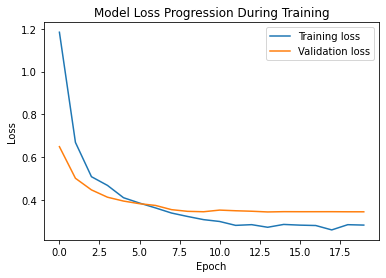

In [ ]:
plt.title("Model Loss Progression During Training")
plt.plot(epochs_info.history['loss'])
plt.plot(epochs_info.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"])
plt.show()

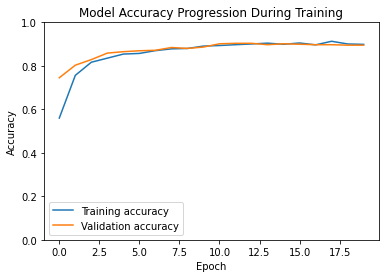

In [ ]:
plt.title("Model Accuracy Progression During Training")
plt.plot(epochs_info.history['accuracy'])
plt.plot(epochs_info.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend(["Training accuracy", "Validation accuracy"])
plt.show()

## Model Evaluation

To evaluate our model we create a new data generator using the images previously separated in the "flower_photos_test" folder. Shuffling is disabled so that we can make predicted and actual labels paired for the confusion matrix.

Using TensorFlow's `evaluate` method, an accuracy of 89% is reported. This is quite good considering that we have only 3670 images and that some images seem to be incorrectly labeled, as shown later.

In [ ]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
)

test_flow = test_datagen.flow_from_directory('/content/flower_photos_test',
                                             batch_size=batch_size,
                                             target_size=(224, 224),
                                             shuffle=False)

mobilenetv2_retrained.evaluate(test_flow)

Found 536 images belonging to 5 classes.
9/9 [==============================] - 18s 2s/step - loss: 0.3162 - accuracy: 0.8918


[0.31619611382484436, 0.891791045665741]

The confusion matrix below summarizes the predictions that our model has made for the 536 test images. The main diagonal has the correct classifications and remaining cells have the incorrect classifications.

The majority of predictions hit the main diagonal. We have mostly true positives, which indicates a very good performance for our model.

Our model makes a notable amount of mistakes saying that class 2 images (roses) belong to class 4 (tulips).

9/9 [==============================] - 18s 2s/step


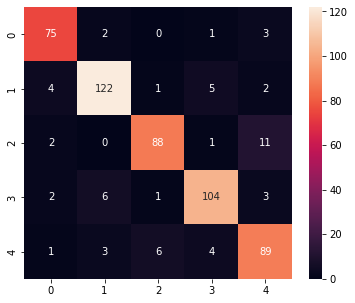

In [ ]:
y_pred = mobilenetv2_retrained.predict(test_flow)

# Get maximum probability predicted as the class selected by the model.
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_flow.labels, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

We can see that `classification_report` from Scikit-learn points to the same overall accuracy of 89%.

Class 4 has the worst precision performance due to the issue already discussed of class 2 members being predicted as class 4. These wrong predictions are false positives for class 4 and false negatives for class 2, hence the low recall for class 2.

In [ ]:
print(classification_report(test_flow.labels, y_pred_classes))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        81
           1       0.92      0.91      0.91       134
           2       0.92      0.86      0.89       102
           3       0.90      0.90      0.90       116
           4       0.82      0.86      0.84       103

    accuracy                           0.89       536
   macro avg       0.89      0.89      0.89       536
weighted avg       0.89      0.89      0.89       536



Lastly, we build a grid of random images taken from the testing set. Along with the images, their actual and predicted labels are shown above them.

For the first error appearing in this grid, in line 3, column 1, there is a daisy flower mislabeled as a rose. Our model understood that it is a daisy. 

For the second error, in line 4, column 1, the sunflower is just a very small patch of a towel in the image. There are no actual flowers in the image.

Conclusively, our mistakes are understandable and our results are pretty good, considering that MobileNetV2 is a network proposed to be less accurate but also less resource intensive. In addition, since the quality of the images is good, it would be easy to perform data augmentation on this dataset. That would increase the number of available images and probably our model's performance.

Found 536 images belonging to 5 classes.
2/2 [==============================] - 3s 930ms/step


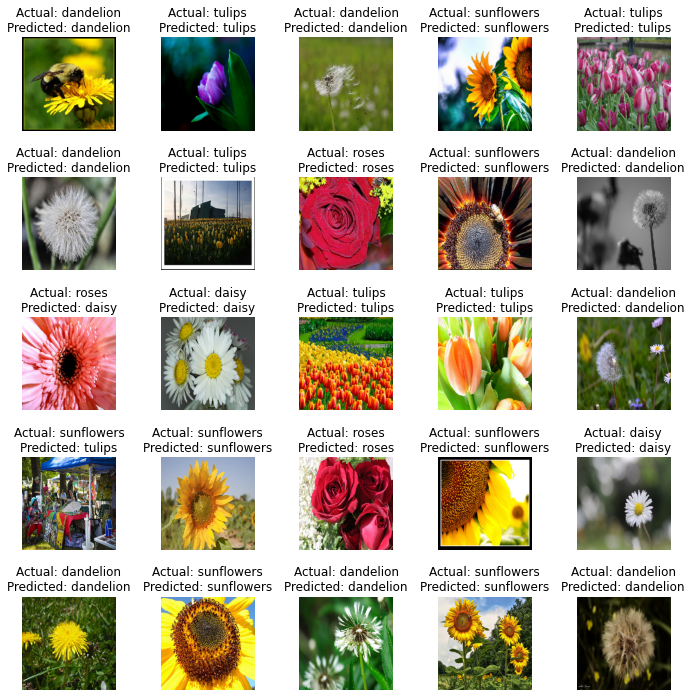

In [ ]:
# New generator to get random images (shuffle=True).
test_flow = test_datagen.flow_from_directory('/content/flower_photos_test',
                                             batch_size=batch_size,
                                             target_size=(224, 224),
                                             seed=0)

# Get first batch as a sample for our grid. Use the previously defined
# labels (class names) to print flower names above the figures.
sample_batch = test_flow.__getitem__(0)[0]
predicted_sample_batch = mobilenetv2_retrained.predict(sample_batch)
predicted_class_ids = np.argmax(predicted_sample_batch, axis=1)
predicted_labels = labels[predicted_class_ids].flatten()

actual_class_ids = np.argmax(test_flow.__getitem__(0)[1].astype(int), axis=1)
actual_labels = labels[actual_class_ids].flatten()

grid_height = 5
grid_width = 5

fig, axes = plt.subplots(grid_height, grid_width, figsize=(12, 12))
axes = axes.ravel()

for i in range(grid_height * grid_width):
    axes[i].imshow(sample_batch[i])
    axes[i].set_title("Actual: {}\nPredicted: {}".format(actual_labels[i],
                                                         predicted_labels[i]))
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.5)
plt.show()